First I will load my dataset, im going to be chaning the names so there is no mixup between mine and Kalinas

✅ RNA Filtered shape: (17535, 29)


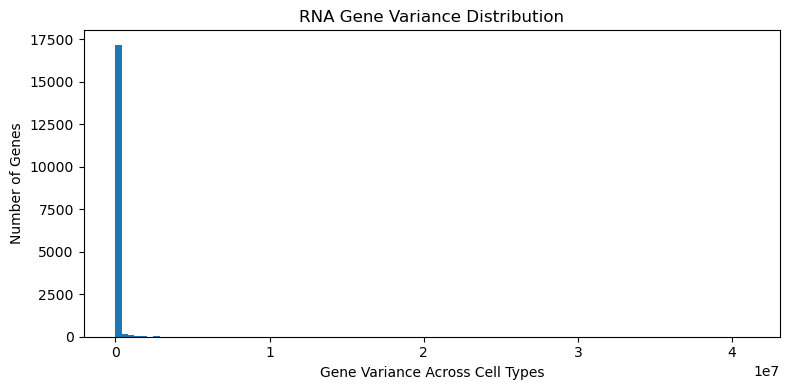

🔹 Original shape: (17535, 29)
🔹 After RNA variance filtering: (8494, 29)


In [2]:
# Step 1: Load dataset
import pandas as pd

rna_df = pd.read_csv("mmc2.csv", index_col=0)

# Step 2: Keep only selected cell types
rna_cell_types_to_keep = [
    "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.4.Sp.aCD3+CD40.18hr", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "T8.TN.P14.Sp", "T8.TE.LCMV.d7.Sp", "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.Gut",
    "T8.Tcm.LCMV.d180.Sp", "T8.Tem.LCMV.d180.Sp",
    "NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d",
    "LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"
]

rna_filtered_df = rna_df[rna_cell_types_to_keep]
rna_filtered_df.to_csv("rna_filtered_abT_Tact_Stem.csv")
print("✅ RNA Filtered shape:", rna_filtered_df.shape)

# Step 3: Plot gene variance distribution
import matplotlib.pyplot as plt

rna_gene_variances = rna_filtered_df.var(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(rna_gene_variances, bins=100)
plt.xlabel("Gene Variance Across Cell Types")
plt.ylabel("Number of Genes")
plt.title("RNA Gene Variance Distribution")
plt.tight_layout()
plt.show()


# Step 4: Filter genes with high variance
rna_var_threshold = 500
rna_high_var_genes = rna_gene_variances[rna_gene_variances > rna_var_threshold].index
rna_refined_df = rna_filtered_df.loc[rna_high_var_genes]

print(f"🔹 Original shape: {rna_filtered_df.shape}")
print(f"🔹 After RNA variance filtering: {rna_refined_df.shape}")




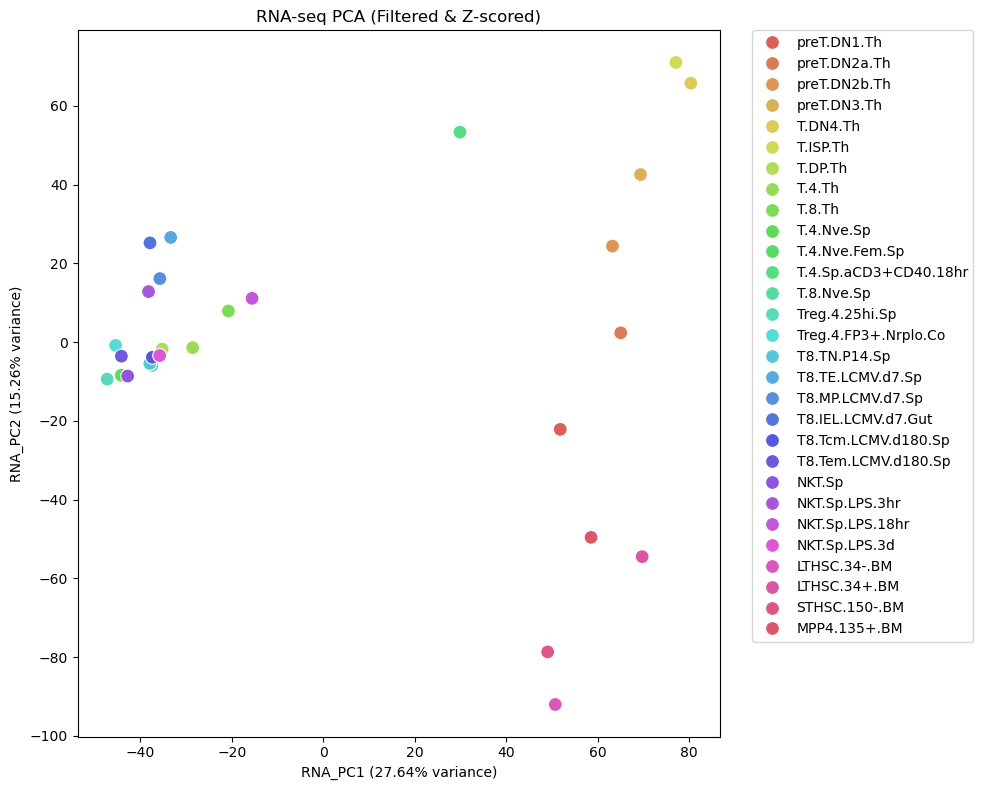

In [3]:
# Step 5: Transpose and scale (Z-score)
from sklearn.preprocessing import StandardScaler

rna_transposed_df = rna_refined_df.T  # rows = samples (cell types), columns = features (genes)

rna_scaler = StandardScaler()
rna_scaled_array = rna_scaler.fit_transform(rna_transposed_df)

# Back to DataFrame
rna_scaled_df = pd.DataFrame(rna_scaled_array, index=rna_transposed_df.index, columns=rna_transposed_df.columns)
rna_scaled_df.head()
# Step 6: PCA
from sklearn.decomposition import PCA

rna_pca_model = PCA(n_components=2)
rna_pca_result = rna_pca_model.fit_transform(rna_scaled_df)
# Step 7: Plot PCA
import seaborn as sns

rna_pca_df = pd.DataFrame(rna_pca_result, columns=["RNA_PC1", "RNA_PC2"], index=rna_scaled_df.index)
rna_pca_df["RNA_CellType"] = rna_pca_df.index

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=rna_pca_df,
    x="RNA_PC1",
    y="RNA_PC2",
    hue="RNA_CellType",
    palette=sns.color_palette("hls", n_colors=rna_pca_df["RNA_CellType"].nunique()),
    s=100
)

plt.xlabel(f"RNA_PC1 ({rna_pca_model.explained_variance_ratio_[0] * 100:.2f}% variance)")
plt.ylabel(f"RNA_PC2 ({rna_pca_model.explained_variance_ratio_[1] * 100:.2f}% variance)")
plt.title("RNA-seq PCA (Filtered & Z-scored)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()



Now I will be loading Kalinas dataset and rename hers

✅ ATAC matrix shape: (512595, 29)


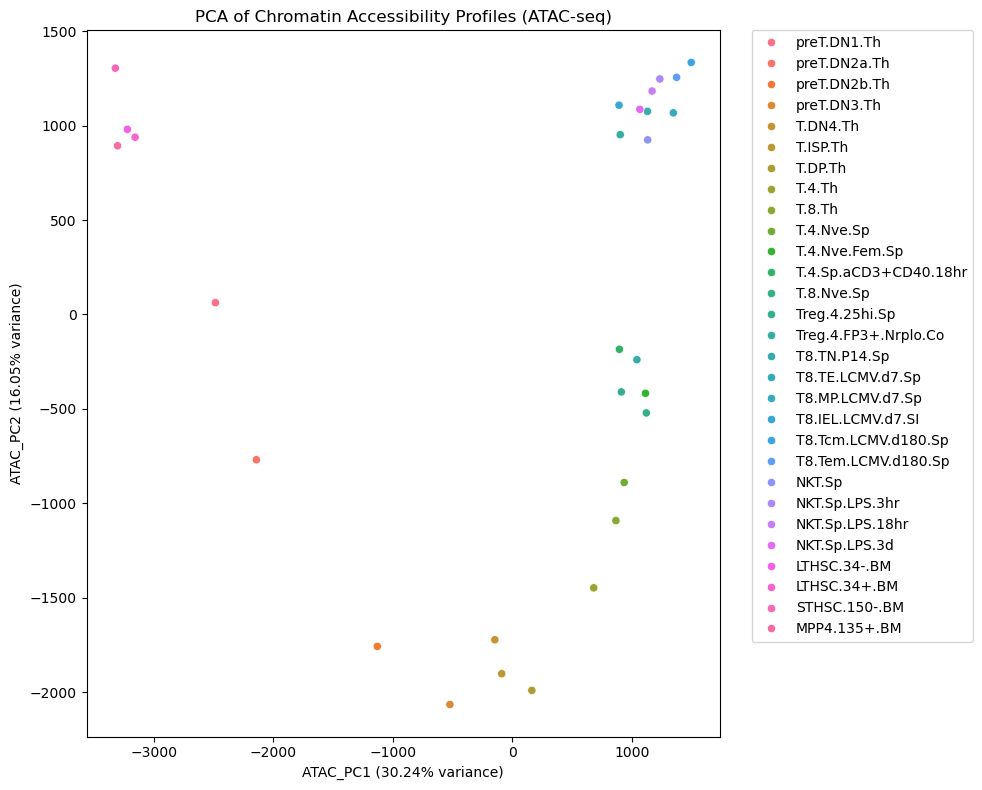

In [4]:
# Step 1: Load ATAC-seq signal matrix
import pandas as pd

atac_peak_matrix = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:]  # drop metadata columns if any
print("✅ ATAC matrix shape:", atac_signal_matrix.shape)
atac_signal_matrix.head()
# Step 2: Transpose so that rows = samples (cell types), columns = features
atac_transposed_df = atac_signal_matrix.T
atac_transposed_df.head()
# Step 3: PCA on ATAC-seq
from sklearn.decomposition import PCA

atac_pca_model = PCA(n_components=2)
atac_pca_result = atac_pca_model.fit_transform(atac_transposed_df)

# Put into DataFrame
atac_pca_df = pd.DataFrame(atac_pca_result, columns=["ATAC_PC1", "ATAC_PC2"], index=atac_transposed_df.index)
atac_pca_df.head()
# Step 4: Plot ATAC PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index so CellType is a column, not an index
atac_pca_df = atac_pca_df.reset_index().rename(columns={"index": "ATAC_CellType"})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=atac_pca_df,
    x="ATAC_PC1",
    y="ATAC_PC2",
    hue="ATAC_CellType"
)

plt.xlabel(f"ATAC_PC1 ({atac_pca_model.explained_variance_ratio_[0] * 100:.2f}% variance)")
plt.ylabel(f"ATAC_PC2 ({atac_pca_model.explained_variance_ratio_[1] * 100:.2f}% variance)")
plt.title("PCA of Chromatin Accessibility Profiles (ATAC-seq)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()


